# Analysis of Simulation Results

### Set up

In [2]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# create dataframe to fill with results


results = pd.DataFrame(
    columns=[
        'model type', 
        'size', 
        'active proportion', 
        'noise', 
        'seed', 
        'selected features', 
        'precision', 
        'recall', 
        'training rmse', 
        'testing rmse', 
        'beta_error', 
        'tune time', 
        'fit time', 
        'prediction time (test)', 
        'total runtime', 
        'lambda'])

In [4]:
def extract_model_type(filename):
    if "l1_gp" in filename:
        return "l1_gp"
    elif "lasso_ard" in filename:
        return "lasso_ard"
    elif "lasso_std" in filename:
        return "lasso_std"
    elif "ard" in filename:
        return "ard"
    elif "std" in filename:
        return "std"
    return "unknown"

In [5]:
# load simulation results from individual files
root_dir = '/Users/liviafingerson/Documents/GitHub/IEMS399-GP/Simulation Datasets'

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):

        try: 
            active_proportion = float(folder_name.split('_')[1][2:]) 
            noise = float(folder_name.split('_')[2][5:])  
            seed = int(folder_name.split('_')[3][4:])

        except ValueError:
            print(f"Skipping folder {folder_name}")
            continue

        for file_name in os.listdir(folder_path):

            for size_folder in os.listdir(folder_path):
                size_folder_path = os.path.join(folder_path, size_folder)
                if os.path.isdir(size_folder_path):
                    for file_name in os.listdir(size_folder_path):
                        if file_name.endswith('results.json'):
                            file_path = os.path.join(size_folder_path, file_name)
                            with open(file_path, 'r') as f:
                                json_data = json.load(f)
                            df = pd.DataFrame([json_data])
                            df["model type"] = extract_model_type(file_name)
                            df['size'] = int(size_folder.replace('Size', ''))
                            df['active proportion'] = active_proportion
                            df['noise'] = noise
                            df['seed'] = seed
                            df['replication'] = int(file_name.split('_')[0].replace('Rep', ''))

                            results = pd.concat([results, df], ignore_index=True)

/var/folders/hh/2dsrbb3d021_w0zs6jdygn480000gn/T/ipykernel_55295/160790974.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, df], ignore_index=True)
/var/folders/hh/2dsrbb3d021_w0zs6jdygn480000gn/T/ipykernel_55295/160790974.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, df], ignore_index=True)
/var/folders/hh/2dsrbb3d021_w0zs6jdygn480000gn/T/ipykernel_55295/160790974.py:35: FutureWarning: The behavior of DataFrame concatenation

In [6]:
results.head()

,model type,size,active proportion,noise,seed,selected features,precision,recall,training rmse,testing rmse,beta_error,tune time,fit time,prediction time (test),total runtime,lambda,replication
0,lasso_std,50,20.0,1.0,5,"[1, 2, 4, 7, 10, 13, 14, 16, 17, 19, 20, 22, 2...",0.333333,0.833333,0.0000,2.9089,0.6055,0.0093,0.3039,0.0633,0.3766,0.273,5.0
1,lasso_ard,50,20.0,1.0,5,"[1, 2, 4, 7, 10, 13, 14, 16, 17, 19, 20, 22, 2...",0.333333,0.833333,0.0000,3.2064,0.6055,0.0091,1.3601,0.0240,1.3932,0.273,5.0
2,l1_gp,50,20.0,1.0,5,[0],0.000000,0.000000,4.2814,4.2000,0.4472,19.7521,0.2174,0.0260,19.9955,0.050,3.0
3,l1_gp,50,20.0,1.0,5,[0],0.000000,0.000000,4.0403,4.3777,0.4472,19.2134,0.2155,0.0181,19.4471,0.050,2.0
4,std,50,20.0,1.0,5,All features,0.000000,0.000000,1.5733,3.1213,0.4472,NaN,0.2610,0.0196,0.2806,NaN,1.0


### Plotting

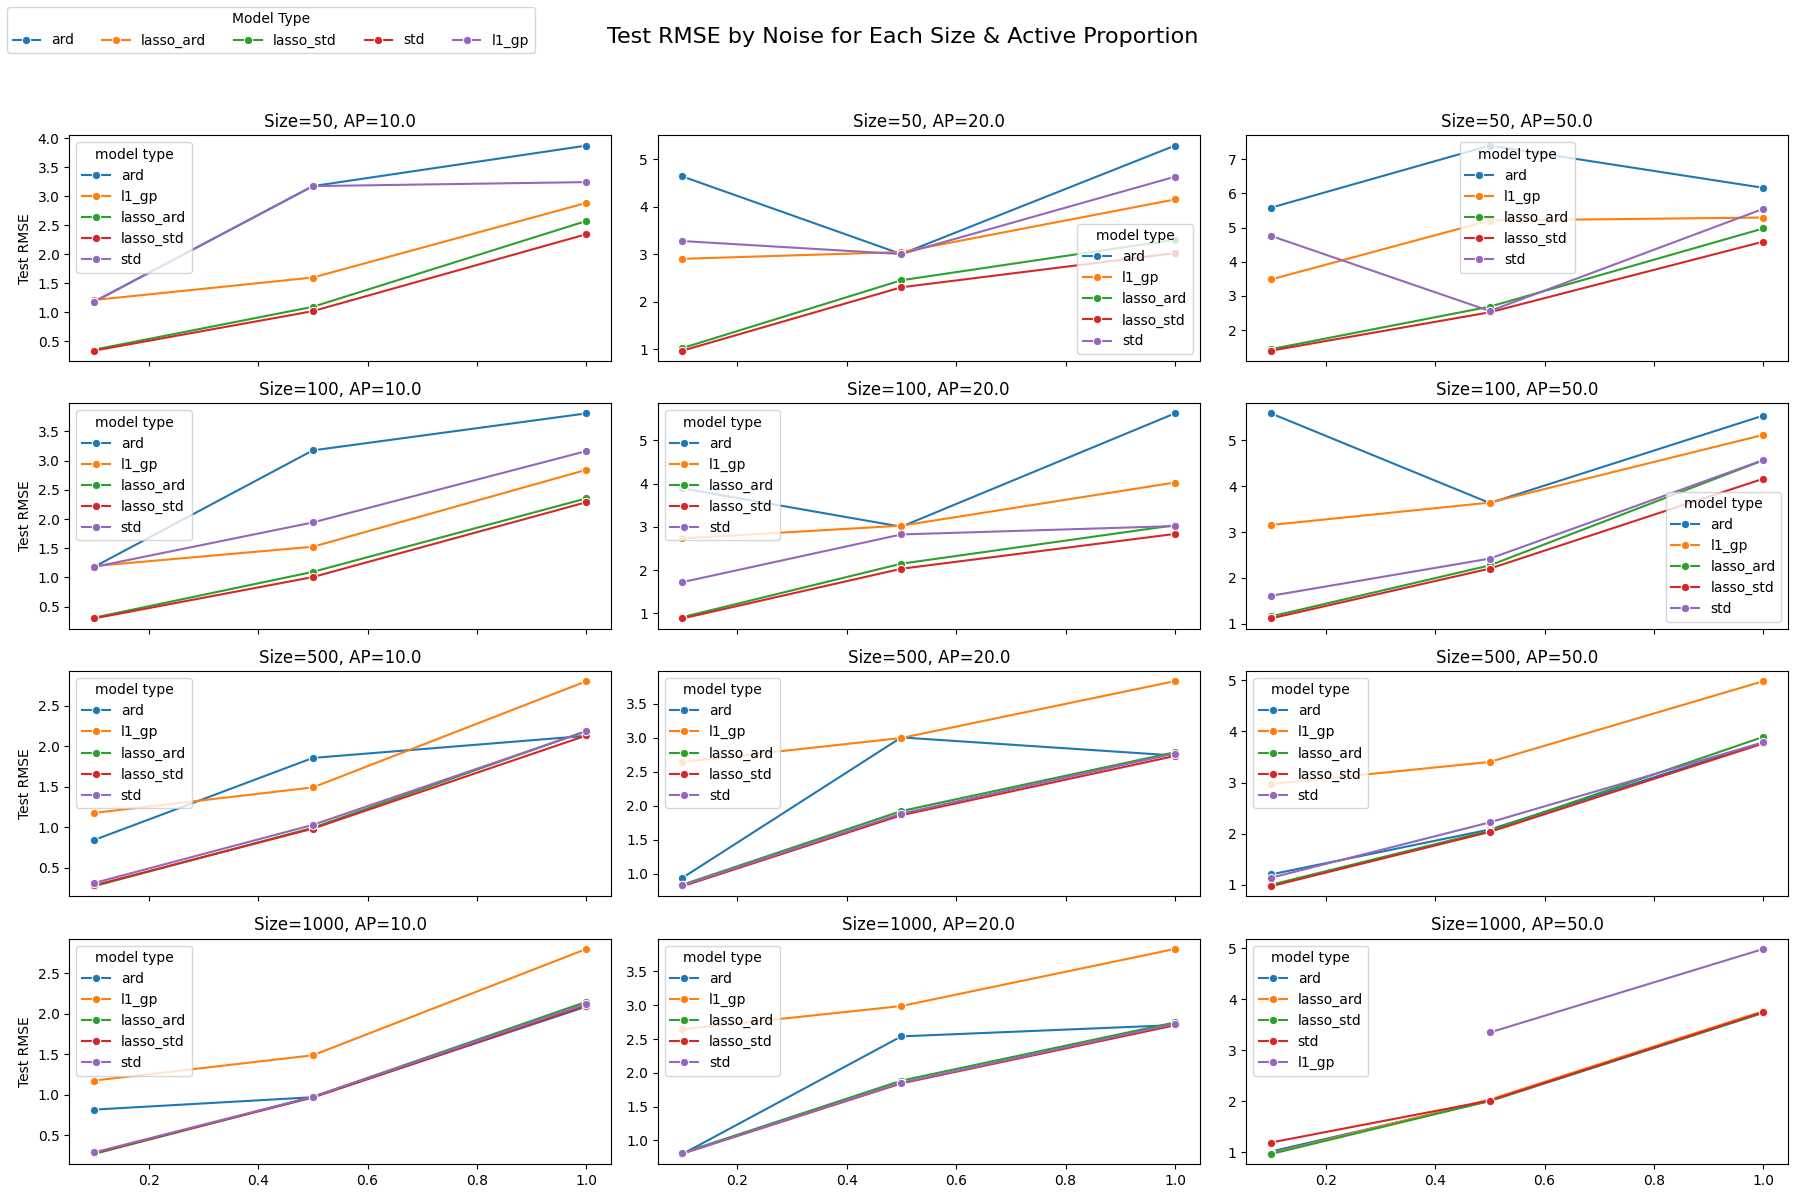

In [11]:
sizes = sorted(results['size'].unique())
aps = sorted(results['active proportion'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)

for i, size in enumerate(sizes):
    for j, ap in enumerate(aps):
        ax = axes[i, j]
        subset = results[(results['size'] == size) & (results['active proportion'] == ap)]

        if subset.empty:
            ax.set_visible(False)
            continue

        rmse_by_noise = (
            subset.groupby(['noise', 'model type'])['testing rmse']
            .mean()
            .reset_index()
        )

        sns.lineplot(data=rmse_by_noise, x='noise', y='testing rmse',
                     hue='model type', marker='o', ax=ax, hue_order=['']) ## fill in

        ax.set_title(f'Size={size}, AP={ap}')
        if i == 2:
            ax.set_xlabel('Noise')
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel('Test RMSE')
        else:
            ax.set_ylabel('')

# Add a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Model Type', loc='upper left', ncol=5)
plt.suptitle('Test RMSE by Noise for Each Size & Active Proportion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


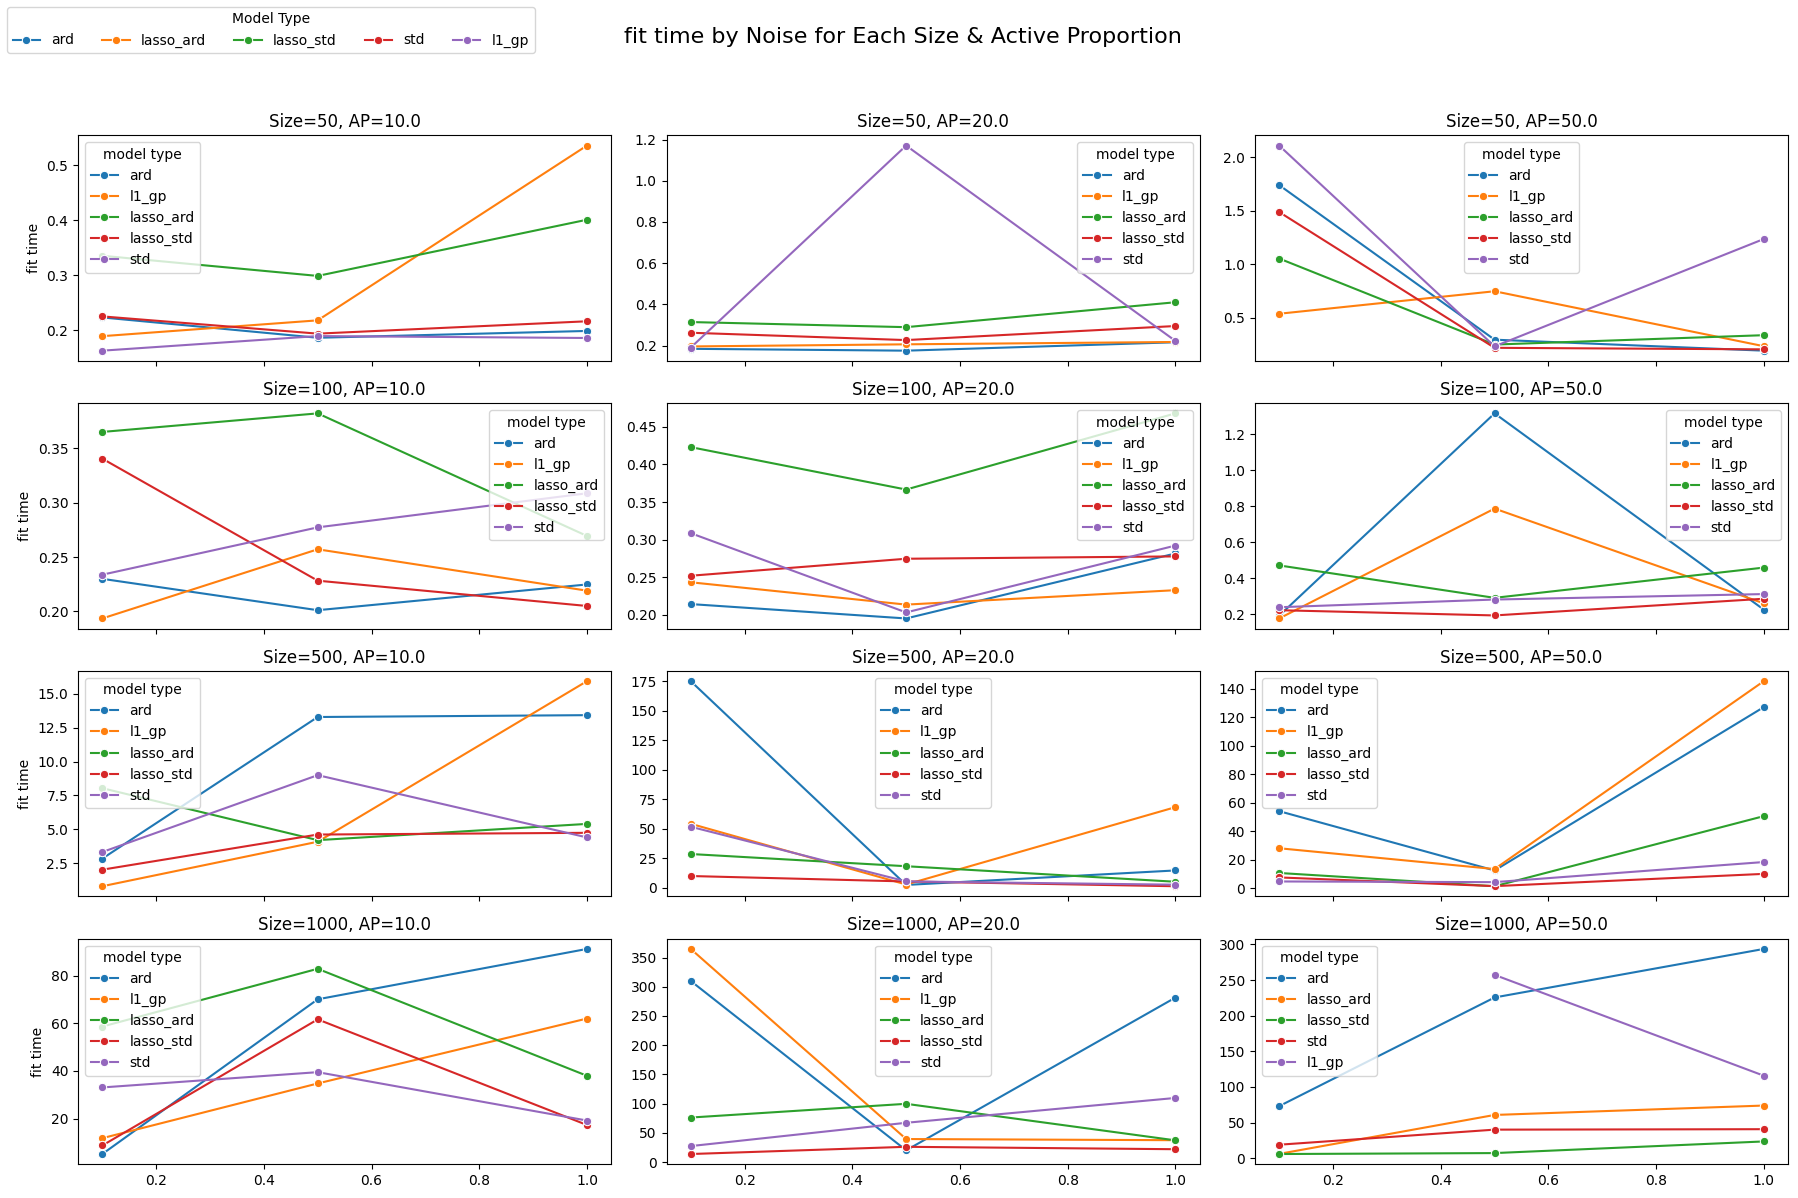

In [10]:
metric = 'fit time' # change this to inspect different metrics

sizes = sorted(results['size'].unique())
aps = sorted(results['active proportion'].unique())

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)

for i, size in enumerate(sizes):
    for j, ap in enumerate(aps):
        ax = axes[i, j]
        subset = results[(results['size'] == size) & (results['active proportion'] == ap)]

        if subset.empty:
            ax.set_visible(False)
            continue

        rmse_by_noise = (
            subset.groupby(['noise', 'model type'])[metric]
            .median()
            .reset_index()
        )

        sns.lineplot(data=rmse_by_noise, x='noise', y=metric,
                     hue='model type', marker='o', ax=ax)

        ax.set_title(f'Size={size}, AP={ap}')
        if i == 2:
            ax.set_xlabel('Noise')
        else:
            ax.set_xlabel('')
        if j == 0:
            ax.set_ylabel(f'{metric}')
        else:
            ax.set_ylabel('')

# Add a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Model Type', loc='upper left', ncol=5)
plt.suptitle(f'{metric} by Noise for Each Size & Active Proportion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()